# 二手房交易分析

## 目标

通过数据分析，对后续二手房交易策略提供支持，计划进行如下维度分析

1. 小区户型交易热点，掌握哪些户型易于成交
2. 用户行为，户型与交易周期的关系，了解一个新挂的二手房，什么情况下可能成交，以及相应的议价空间
3. 交易趋势，确认政策对交易的量化影响，以及目前的价格走势

随后形成如下认知：

1. 户型后续出手难度
2. 户型定价策略，报价博弈策略
3. 潜在竞争客户应对策略

最终用户如下决策

1. 买什么户型
2. 报多少价格
3. 如何进行议价

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）
pd.set_option("display.max_rows", None)
#pd.reset_option("display.max_rows")

# 一. 数据载入&预处理

In [3]:
# 载入数据
data = pd.read_csv('../慧忠里.csv')

In [4]:
# 预览数据
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,listing_time,last_transaction_duration,transaction_price,history_trade_count,listed_price,transaction_duration,price_change_count,visit_count,follower_count,page_view_count
0,慧忠里 1室1厅 45.36平米,2019.08.19,慧忠里,1室1厅1厨1卫,中楼层(共6层),45.36㎡,板楼,西南,1991,101105487757,2019-08-16,暂无数据,365,2,385,3,0,0,0,暂无数据
1,慧忠里 2室1厅 46.42平米,2019.06,慧忠里,2室1厅1厨1卫,顶层(共6层),46.42㎡,板楼,南 北,1991,101104427973,2019-04-04,暂无数据,385-426,1,460,58,0,12,0,3
2,慧忠里 3室1厅 83.91平米,2019.04,慧忠里,3室1厅1厨1卫,中楼层(共6层),83.91㎡,板楼,南 北,1993,101103884394,2018-12-22,满五年,627-693,1,690,101,0,41,143,3709


In [5]:
# 预览大小和特征数
data.shape

(1039, 20)

In [6]:
#处理日期数据
data['deal_date'] = pd.to_datetime(data['deal_date'])
data['listing_time'] = pd.to_datetime(data['listing_time'], errors='coerce')
data['deal_month'] = data['deal_date'].dt.to_period('M').dt.to_timestamp()
data['deal_year'] = data['deal_date'].dt.to_period('Y').dt.to_timestamp()

In [7]:
# 处理数值型数据转换
# 成交周期
data['transaction_duration'] = data['transaction_duration'].map(lambda x: np.nan if x=='暂无数据' or x is np.nan else int(x)).astype('Int64',errors='ignore')
# 面积
data['area'] = data['area'].map(lambda x: float(x.strip('㎡') if x != '暂无数据' else np.nan))
# 成交价
def convert_int(numberStr):
    if isinstance(numberStr, int) or isinstance(numberStr, float):
        return numberStr
    if numberStr == '暂无数据':
        return np.nan
    elif '.' in numberStr:
        return int(numberStr.split('.')[0])
    elif '-' not in numberStr:
        return int(numberStr)
    else:
        low,up = numberStr.split('-')
        return int((int(low)+int(up))/2)
data['transaction_price'] = data['transaction_price'].map(convert_int)

# 挂牌价
data['listed_price'] = data['listed_price'].map(convert_int).astype('Int64')

# 浏览数
data['page_view_count'] = data['page_view_count'].map(convert_int).astype('Int64')

In [8]:
#处理字符串类型
# 朝向
data['orientation'] = data['orientation'].map(lambda x: ''.join(set([i for i in x if i != ' '])))

In [50]:
# 新列
data['per_area_price'] = data['transaction_price']/data['area']
data['transaction_listed_price_gap'] = data['transaction_price']-data['listed_price']

def convert_area_level(area):
    return int(round(area/10))*10

def convert_room_count(house_type):
    try:
        return int(house_type[0])
    except Exception:
        return 0

# 面积阶梯
data['area_level'] = data['area'].map(convert_area_level)
data['room_count'] = data['house_type'].map(convert_room_count)

In [45]:
data.dtypes

title                                   object
deal_date                       datetime64[ns]
community                               object
house_type                              object
floor                                   object
area                                   float64
building_type                           object
orientation                             object
build_year                               int64
lianjia_id                              object
listing_time                    datetime64[ns]
last_transaction_duration               object
transaction_price                        int64
history_trade_count                      int64
listed_price                             Int64
transaction_duration                     Int64
price_change_count                       int64
visit_count                              int64
follower_count                           int64
page_view_count                          Int64
deal_month                      datetime64[ns]
deal_year    

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 25 columns):
title                           1039 non-null object
deal_date                       1039 non-null datetime64[ns]
community                       1039 non-null object
house_type                      1039 non-null object
floor                           1039 non-null object
area                            1039 non-null float64
building_type                   1039 non-null object
orientation                     1039 non-null object
build_year                      1039 non-null int64
lianjia_id                      1039 non-null object
listing_time                    1038 non-null datetime64[ns]
last_transaction_duration       1039 non-null object
transaction_price               1039 non-null int64
history_trade_count             1039 non-null int64
listed_price                    1002 non-null Int64
transaction_duration            720 non-null Int64
price_change_count              10

In [51]:
data.head(3)

,title,deal_date,community,house_type,floor,area,building_type,orientation,build_year,lianjia_id,...,price_change_count,visit_count,follower_count,page_view_count,deal_month,deal_year,per_area_price,transaction_listed_price_gap,area_level,room_count
0,慧忠里 1室1厅 45.36平米,2019-08-19,慧忠里,1室1厅1厨1卫,中楼层(共6层),45.36,板楼,南西,1991,101105487757,...,0,0,0,NaN,2019-08-01,2019-01-01,8.046737,-20,40,1
1,慧忠里 2室1厅 46.42平米,2019-06-01,慧忠里,2室1厅1厨1卫,顶层(共6层),46.42,板楼,南北,1991,101104427973,...,0,12,0,3,2019-06-01,2019-01-01,8.724688,-55,40,2
2,慧忠里 3室1厅 83.91平米,2019-04-01,慧忠里,3室1厅1厨1卫,中楼层(共6层),83.91,板楼,南北,1993,101103884394,...,0,41,143,3709,2019-04-01,2019-01-01,7.865570,-30,80,3


# 二. 数据分析

户型种类

In [13]:
print(data['house_type'].unique())

['1室1厅1厨1卫' '2室1厅1厨1卫' '3室1厅1厨1卫' '3室2厅1厨1卫' '3室2厅1厨2卫' '- -室- -厅'
 '2室1厅1厨2卫' '2室2厅1厨1卫' '1室0厅1厨1卫' '3室1厅1厨2卫' '1室2厅1厨1卫' '2室2厅1厨2卫'
 '1室1厅0厨1卫']


建成年代

In [14]:
print(data['build_year'].unique())

[1991 1993 1990 1992 1994 1997 1999 1995 1996]


## 2.1 交易行为

### 1）户型交易分布

可以查看交易主力户型和朝向

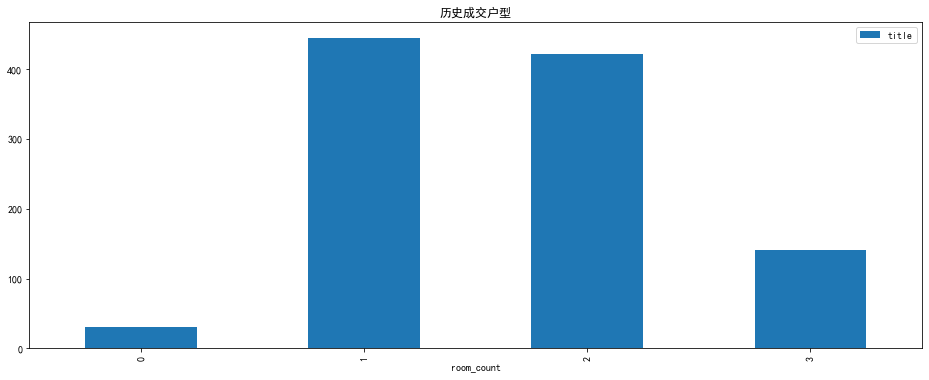

In [53]:
data.groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型')

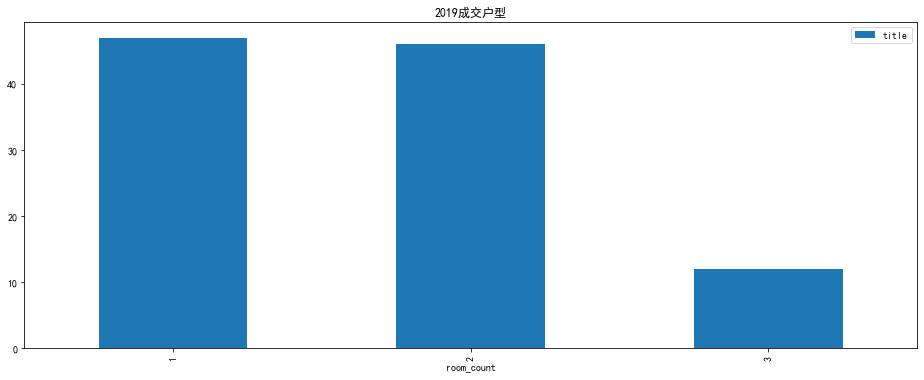

In [55]:
data[data['deal_date']>='2019'].groupby(['room_count']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交户型')

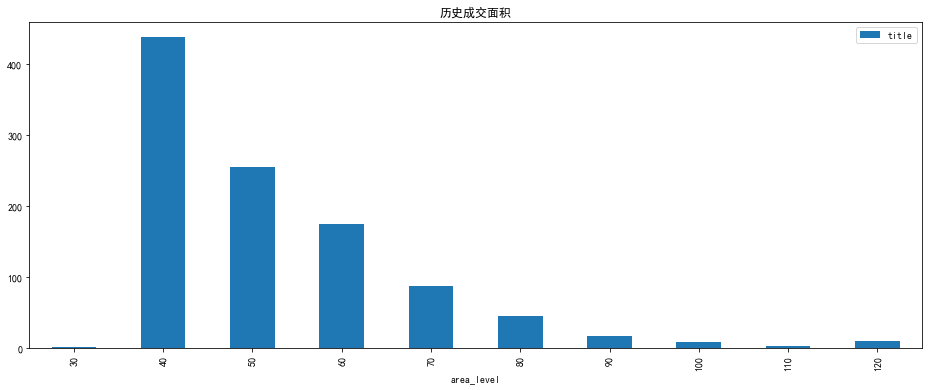

In [48]:
data.groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交面积')

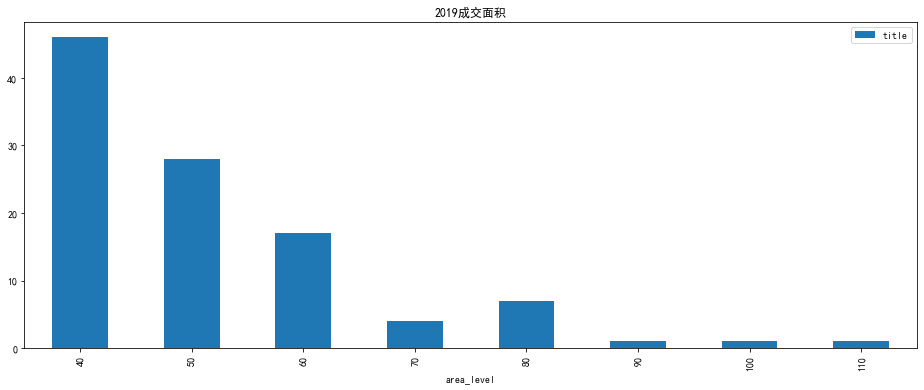

In [49]:
data[data['deal_date']>='2019'].groupby(['area_level']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019成交面积')

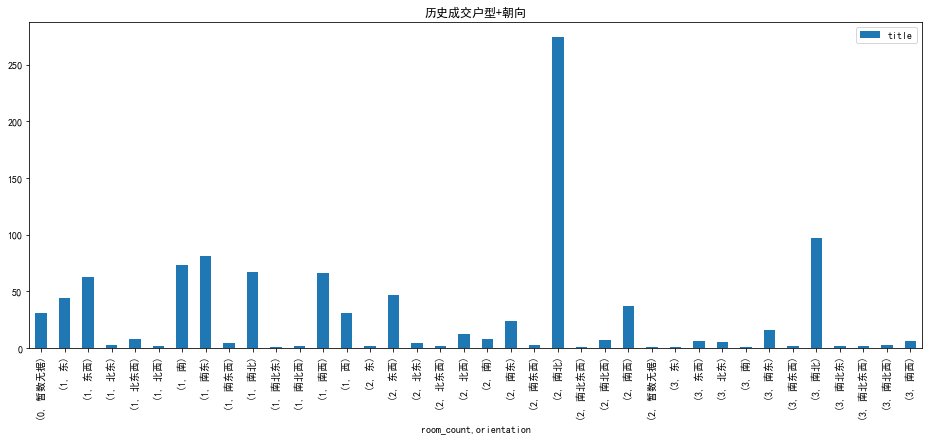

In [52]:
data.groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交户型+朝向')

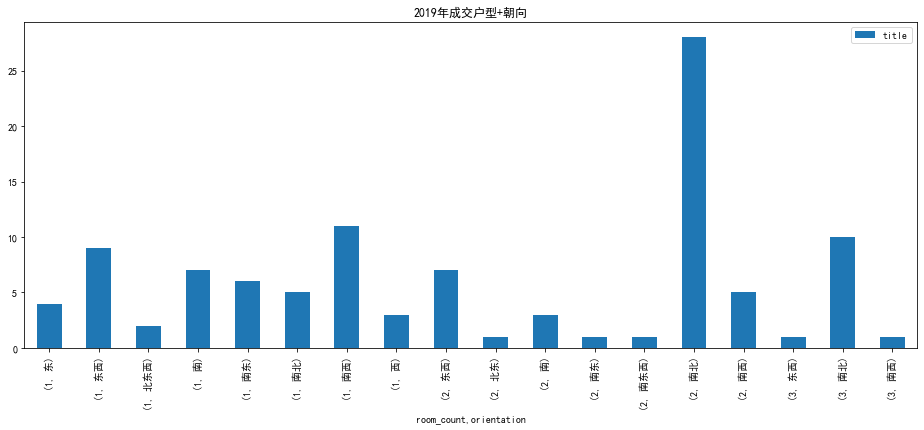

In [54]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交户型+朝向')

分户型朝向和楼层的成交分布

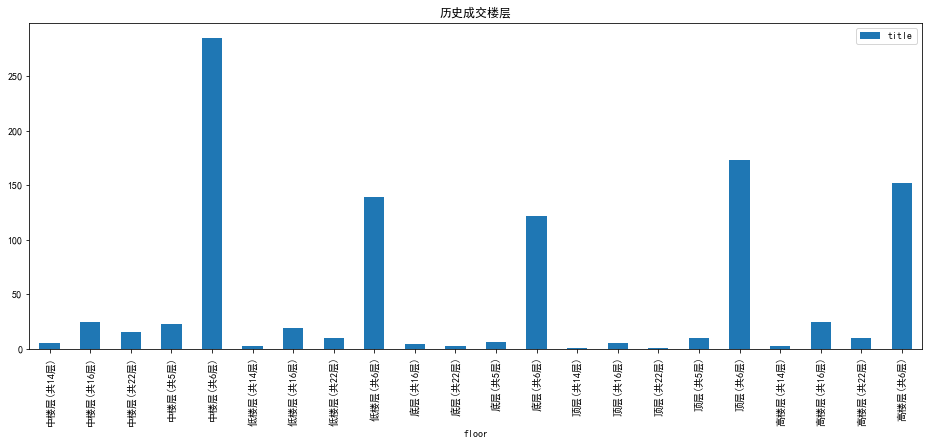

In [18]:
data.groupby(['floor']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交楼层')

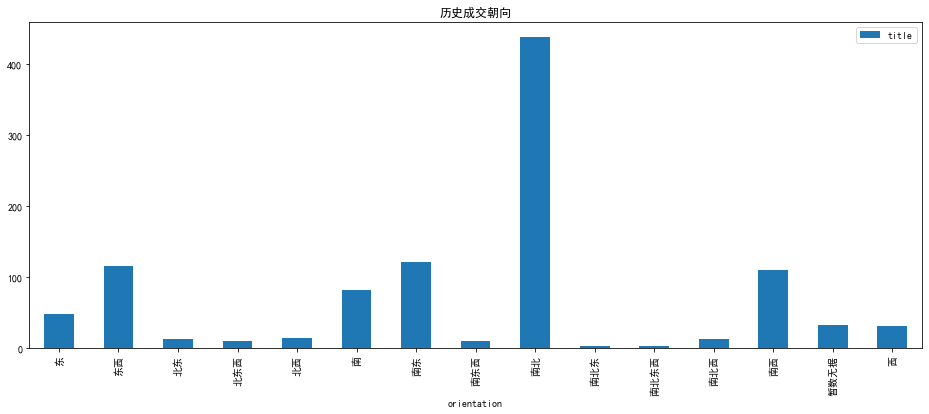

In [19]:
data.groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='历史成交朝向')

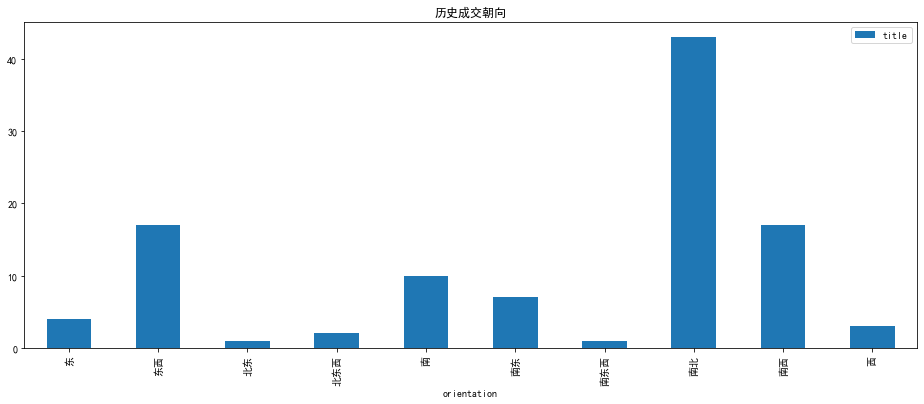

In [20]:
data[data['deal_date']>='2019'].groupby(['orientation']).count()[['title']].plot(kind='bar', figsize=(16,6), title='2019年成交朝向')

In [21]:
data.groupby(['house_type','orientation','floor']).count()[['title']]

title
house_type orientation floor           
- -室- -厅   暂数无据        中楼层(共16层)      1
                       中楼层(共5层)       1
                       中楼层(共6层)       6
                       低楼层(共6层)       4
                       底层(共6层)        5
                       顶层(共14层)       1
                       顶层(共6层)        8
                       高楼层(共22层)      1
                       高楼层(共6层)       4
1室0厅1厨1卫   东           高楼层(共6层)       1
           东西          顶层(共6层)        1
           南东          中楼层(共6层)       1
                       顶层(共6层)        1
           南北          高楼层(共6层)       1
           南西          中楼层(共6层)       1
                       低楼层(共6层)       1
           西           中楼层(共6层)       1
                       低楼层(共6层)       1
                       高楼层(共6层)       1
1室1厅0厨1卫   西           高楼层(共6层)       1
1室1厅1厨1卫   东           中楼层(共6层)      14
                       低楼层(共6层)       5
                       底层(共6层)        5
                       顶层(共6层)        7
                       高楼层(共6层)      12
           东西          中楼层(共6层)      18
                       低楼层(共6层)      11
                       底层(共6层)        9
                       顶层(共6层)       15
                       高楼层(共6层)       8
           北东          低楼层(共6层)       1
                       底层(共6层)        1
                       高楼层(共6层)       1
           北东西         中楼层(共6层)       2
                       低楼层(共6层)       3
                       高楼层(共6层)       3
           北西          低楼层(共6层)       1
                       顶层(共6层)        1
           南           中楼层(共16层)      2
                       中楼层(共6层)      18
                       低楼层(共16层)      3
                       低楼层(共6层)      11
                       底层(共5层)        1
                       底层(共6层)       12
                       顶层(共16层)       1
                       顶层(共5层)        2
                       顶层(共6层)        8
                       高楼层(共16层)      3
                       高楼层(共6层)      12
           南东          中楼层(共16层)      5
                       中楼层(共6层)      26
                       低楼层(共16层)      5
                       低楼层(共6层)       7
                       底层(共6层)        9
                       顶层(共16层)       2
                       顶层(共6层)        8
                       高楼层(共16层)      5
                       高楼层(共6层)      12
           南东西         低楼层(共6层)       1
                       底层(共6层)        1
                       顶层(共6层)        1
                       高楼层(共6层)       1
           南北          中楼层(共5层)       4
                       中楼层(共6层)      18
                       低楼层(共6层)      11
                       底层(共5层)        1
                       底层(共6层)        7
                       顶层(共5层)        2
                       顶层(共6层)       15
                       高楼层(共6层)       7
           南北西         中楼层(共6层)       1
                       顶层(共6层)        1
           南西          中楼层(共16层)      1
                       中楼层(共6层)      26
                       低楼层(共16层)      1
                       低楼层(共6层)      10
                       底层(共16层)       1
                       底层(共5层)        1
                       底层(共6层)        7
                       顶层(共6层)        7
                       高楼层(共16层)      1
                       高楼层(共6层)       9
           西           中楼层(共6层)      10
                       低楼层(共6层)       7
                       底层(共6层)        3
                       顶层(共6层)        3
                       高楼层(共6层)       4
1室2厅1厨1卫   东西          底层(共6层)        1
           南北          底层(共6层)        1
           南北东         中楼层(共6层)       1
2室1厅1厨1卫   东           低楼层(共6层)       1
                       顶层(共6层)        1
           东西          中楼层(共6层)      11
                       低楼层(共6层)      10
                       底层(共6层)        7
                       顶层(共6层)       12
                       高楼层(共6层)       7
           北东          中楼层(共5层)       1
                       顶层(共5层)    

### 2）换手率

分户型分析换手情况

成交超过1次，分户型交易占比

In [56]:
data.groupby(['room_count', 'history_trade_count']).count()[['title']]

title
room_count history_trade_count       
0          1                       29
           2                        2
1          1                      356
           2                       77
           3                       12
2          1                      383
           2                       39
3          1                      130
           2                       11

In [57]:
(data[data['history_trade_count']>1].groupby('room_count').count()/2/data.groupby('room_count').count())[['title']]

,title
room_count,
0,0.032258
1,0.100000
2,0.046209
3,0.039007


### 3）带看与成交周期

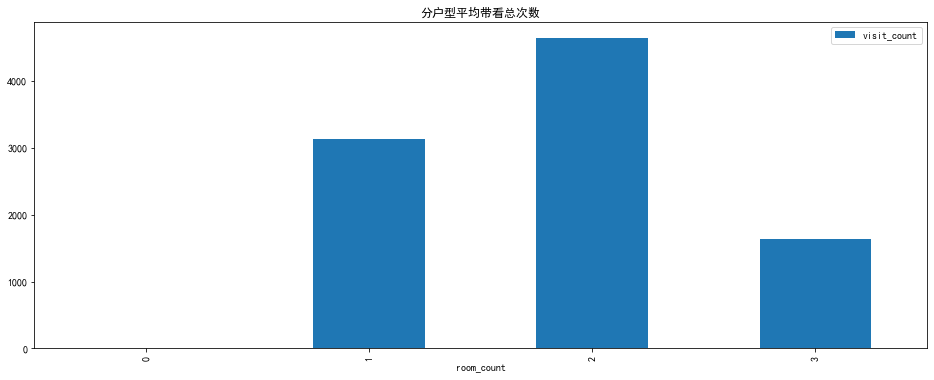

In [61]:
data.groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型平均带看总次数')

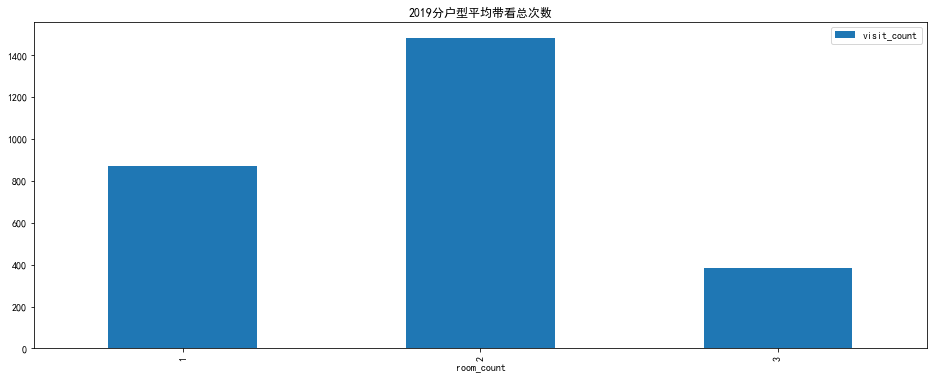

In [62]:
data[data['deal_date']>='2019'].groupby(['room_count']).sum()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019分户型平均带看总次数')

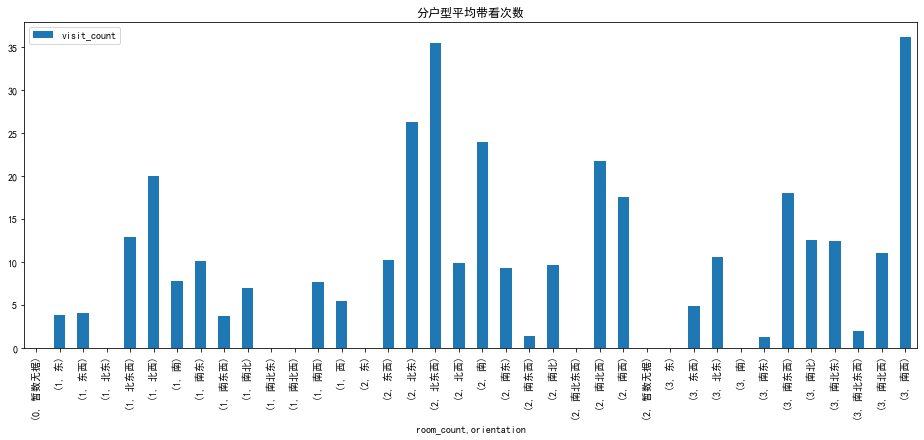

In [58]:
data.groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='分户型+朝向平均带看次数')

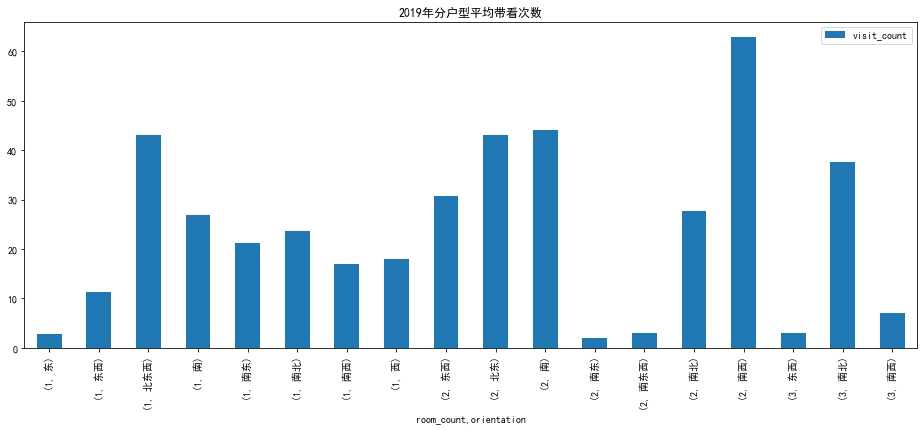

In [59]:
data[data['deal_date']>='2019'].groupby(['room_count','orientation']).mean()[['visit_count']].plot(kind='bar', figsize=(16,6), title='2019年分户型+朝向平均带看次数')

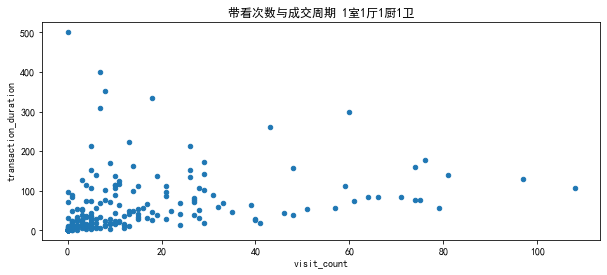

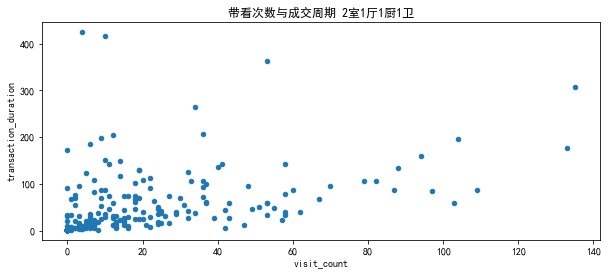

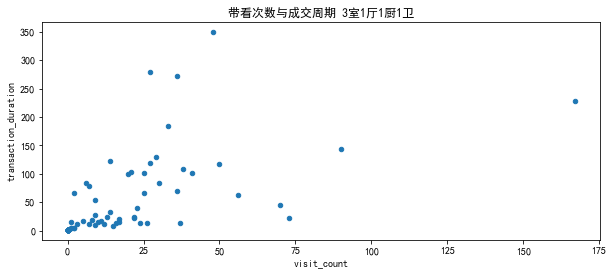

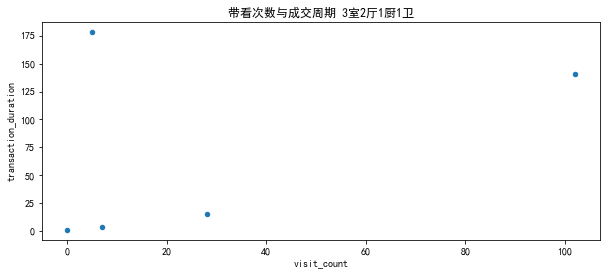

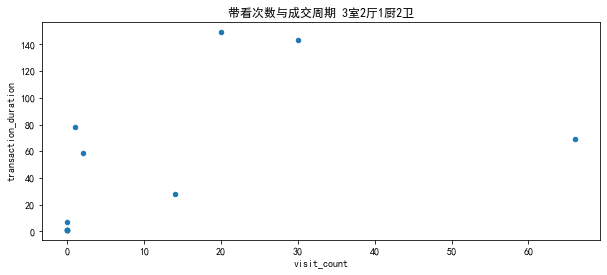

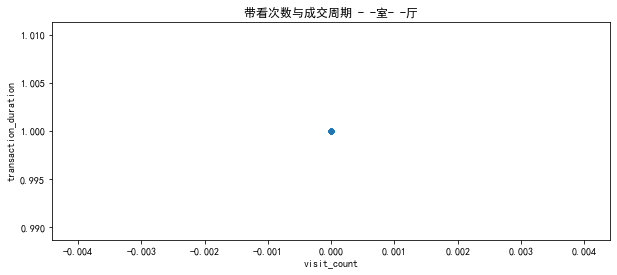

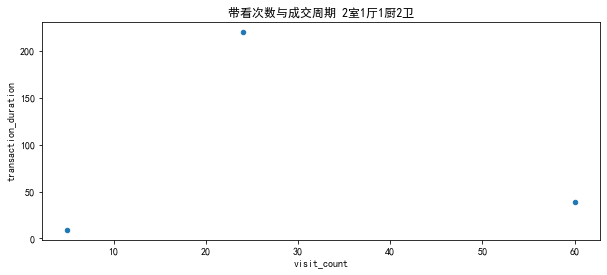

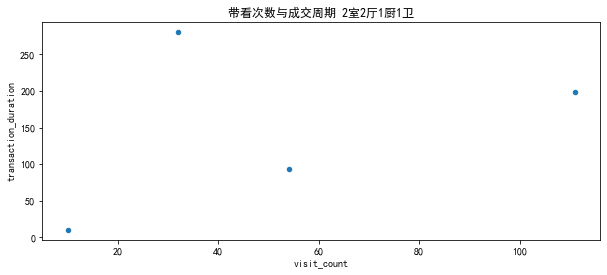

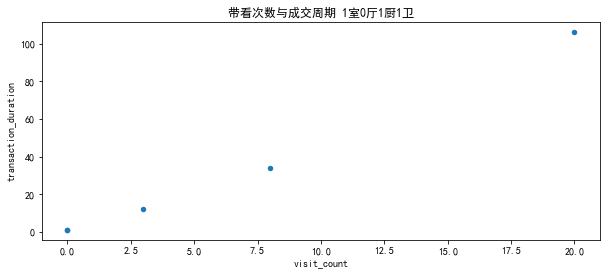

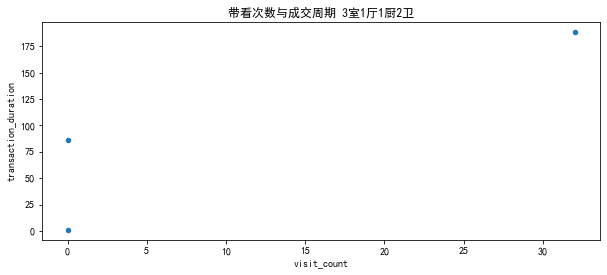

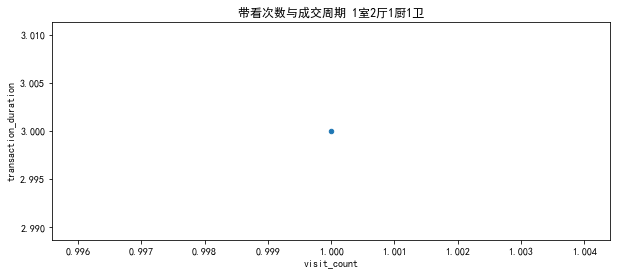

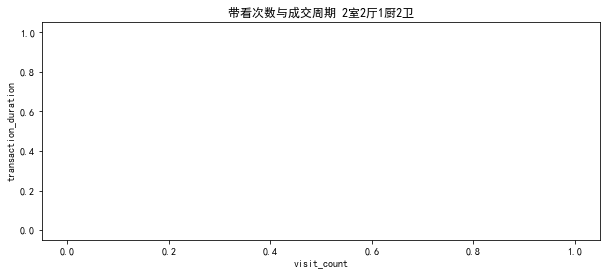

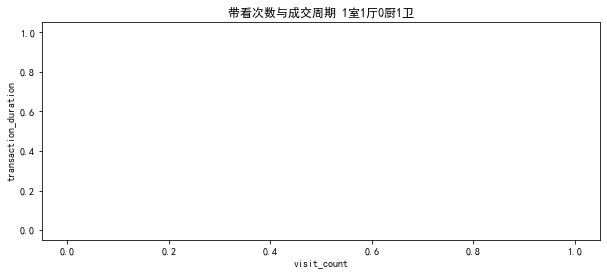

In [26]:
for t in data['house_type'].unique():
    data[data['house_type']==t][['transaction_duration','visit_count']].plot(kind='scatter',x='visit_count', y='transaction_duration',figsize=(10,4),title='带看次数与成交周期 '+t)

分户型成交周期分布

In [63]:
data.groupby(['room_count','orientation','floor']).describe()[['transaction_duration']]

transaction_duration                          \
                                                count        mean         std   
room_count orientation floor                                                    
0          暂数无据        中楼层(共16层)                  1.0    1.000000         NaN   
                       中楼层(共5层)                   1.0    1.000000         NaN   
                       中楼层(共6层)                   5.0    1.000000    0.000000   
                       低楼层(共6层)                   4.0    1.000000    0.000000   
                       底层(共6层)                    5.0    1.000000    0.000000   
                       顶层(共14层)                   1.0    1.000000         NaN   
                       顶层(共6层)                    8.0    1.000000    0.000000   
                       高楼层(共22层)                  1.0    1.000000         NaN   
                       高楼层(共6层)                   4.0    1.000000    0.000000   
1          东           中楼层(共6层)                   8.0   32.750000   44.351679   
                       低楼层(共6层)                   3.0   16.666667   27.135463   
                       底层(共6层)                    4.0  137.500000  179.987963   
                       顶层(共6层)                    3.0   37.333333   60.351747   
                       高楼层(共6层)                   7.0   30.000000   42.469597   
           东西          中楼层(共6层)                  12.0   28.583333   42.294333   
                       低楼层(共6层)                   6.0   69.500000  108.313896   
                       底层(共6层)                    8.0   24.375000   42.203377   
                       顶层(共6层)                   11.0   37.818182   87.638825   
                       高楼层(共6层)                   6.0   44.000000   66.063606   
           北东          低楼层(共6层)                   1.0    1.000000         NaN   
                       底层(共6层)                    1.0    1.000000         NaN   
                       高楼层(共6层)                   1.0    1.000000         NaN   
           北东西         中楼层(共6层)                   2.0   31.500000   26.162951   
                       低楼层(共6层)                   1.0   11.000000         NaN   
                       高楼层(共6层)                   3.0   56.333333   34.961884   
           北西          低楼层(共6层)                   1.0   27.000000         NaN   
                       顶层(共6层)                    0.0         NaN         NaN   
           南           中楼层(共16层)                  2.0   65.500000   70.003571   
                       中楼层(共6层)                  15.0   14.866667   20.212679   
                       低楼层(共16层)                  3.0   47.000000   79.674337   
                       低楼层(共6层)                   7.0   65.857143  127.773796   
                       底层(共5层)                    1.0   41.000000         NaN   
                       底层(共6层)                    8.0   14.875000   38.841942   
                       顶层(共16层)                   1.0   84.000000         NaN   
                       顶层(共5层)                    1.0    1.000000         NaN   
                       顶层(共6层)                    7.0   16.142857   19.658998   
                       高楼层(共16层)                  2.0   38.500000   53.033009   
                       高楼层(共6层)                   8.0   13.375000   19.892120   
           南东          中楼层(共16层)                  3.0    9.333333   14.433757   
                       中楼层(共6层)                  21.0   35.809524   40.874954   
                       低楼层(共16层)                  2.0   92.500000   98.287843   
                       低楼层(共6层)                   4.0   13.000000   11.775681   
                       底层(共6层)                    8.0   48.625000   64.511212   
                       顶层(共16层)                   2.0   15.000000   19.798990   
                       顶层(共6层)                    7.0   87.428571   82.999713   
                       高楼层(共16层)                  3.0   11.666667   17.616280   
                       高楼层(共6层)                  12.0   30.25000

## 2.2 价格机制

相同面积，房间数下，影响价格的因素主要是朝向和楼层

### 1）分户型平均成交价格走势

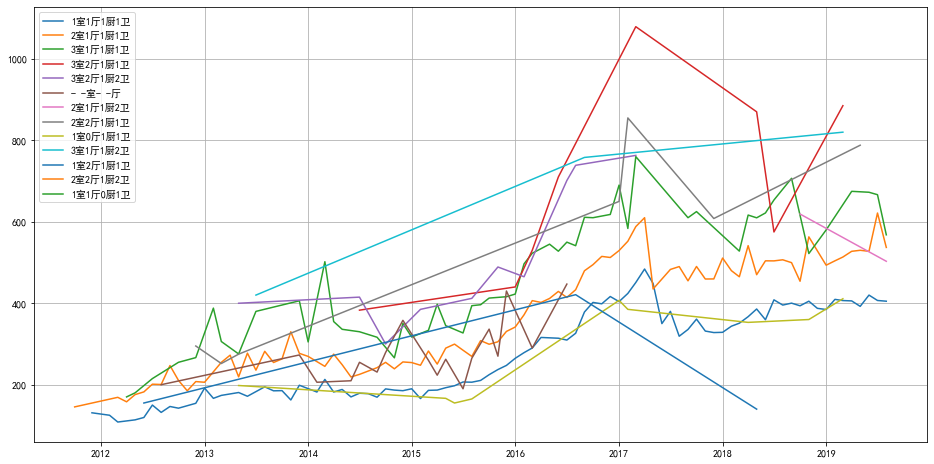

In [28]:
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_price'])
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.show()

### 2）2019年分户型不同楼层成交均价

In [29]:
data[data['deal_date']>'2019'].groupby(['house_type','area','floor', 'build_year'])[['transaction_price','per_area_price']].mean()

transaction_price  per_area_price
house_type area   floor     build_year                                   
1室0厅1厨1卫   40.86  低楼层(共6层)  1991               411.000000       10.058737
1室1厅1厨1卫   40.80  中楼层(共6层)  1993               394.000000        9.656863
                  高楼层(共6层)  1993               377.000000        9.240196
           40.86  低楼层(共6层)  1991               403.000000        9.862947
           44.47  底层(共6层)   1993               395.000000        8.882393
           45.19  低楼层(共6层)  1993               354.000000        7.833592
                  顶层(共6层)   1993               350.000000        7.745076
           45.26  底层(共5层)   1991               445.000000        9.832081
           45.35  高楼层(共6层)  1991               410.000000        9.040794
           45.36  中楼层(共6层)  1991               398.800000        8.791887
                  顶层(共6层)   1991               390.000000        8.597884
                  高楼层(共6层)  1991               411.000000        9.060847
           45.50  中楼层(共6层)  1993               404.666667        8.893773
                  顶层(共6层)   1993               382.000000        8.395604
                  高楼层(共6层)  1991               412.000000        9.054945
           45.52  中楼层(共6层)  1991               417.000000        9.160808
           45.72  低楼层(共6层)  1993               418.000000        9.142607
           45.76  高楼层(共6层)  1994               415.000000        9.069056
           46.04  中楼层(共6层)  1993               419.000000        9.100782
           46.32  中楼层(共6层)  1993               420.000000        9.067358
           46.48  中楼层(共6层)  1993               406.000000        8.734940
                  低楼层(共6层)  1993               360.000000        7.745267
                  高楼层(共6层)  1993               400.000000        8.605852
           46.71  高楼层(共6层)  1993               402.500000        8.616999
           46.80  中楼层(共6层)  1990               429.000000        9.166667
                  低楼层(共6层)  1993               407.000000        8.696581
                  底层(共6层)   1991               400.000000        8.547009
                  高楼层(共6层)  1991               424.000000        9.059829
           47.12  顶层(共6层)   1991               393.000000        8.340407
           47.15  低楼层(共6层)  1992               383.000000        8.123012
           47.46  低楼层(共6层)  1992               361.000000        7.606405
           47.72  底层(共5层)   1990               418.000000        8.759430
           47.99  中楼层(共6层)  1990               400.000000        8.335070
                  高楼层(共6层)  1990               415.000000        8.647635
           48.80  中楼层(共6层)  1992               423.000000        8.668033
           50.43  顶层(共16层)  1992               430.000000        8.526671
           52.90  低楼层(共16层) 1992               463.000000        8.752363
2室1厅1厨1卫   46.42  顶层(共6层)   1991               405.000000        8.724688
           51.67  中楼层(共6层)  1993               445.000000        8.612348
           54.02  底层(共6层)   1994               475.000000        8.793040
           56.01  底层(共6层)   1991               509.000000        9.087663
           56.16  低楼层(共6层)  1992               512.000000        9.116809
           57.27  中楼层(共6层)  1993               540.000000        9.429020
                  高楼层(共6层)  1993               517.000000        9.027414
           57.51  中楼层(共6层)  1993               529.000000        9.198400
                  底层(共6层)   1993               536.500000        9.328812
                  顶层(共6层)   1993               464.000000        8.068162
           57.60  低楼层(共6层)  1993               530.000000        9.201389
           57.72  底层(共6层)   1993               491.000000        8.506584
                  高楼层(共6层)  1993               513.000000        8.887734
           58.25  中楼层(共6层)  1990               528.000000        9.064378
           58.36  底层(共6层)   1990               538.000000        9.218643
           58.45  低楼层(共6层)  1993            

### 3）各个户型最后成交价格

户型锚定价格

In [40]:
data.sort_values('deal_date').groupby(['house_type','area','floor'])[['transaction_price','deal_date']].last()

transaction_price  deal_date
house_type area   floor                                  
- -室- -厅   40.86  低楼层(共6层)                 235 2015-10-01
           41.02  低楼层(共6层)                 270 2015-11-01
           45.36  中楼层(共6层)                 185 2015-05-01
                  顶层(共6层)                  290 2016-03-01
           45.72  高楼层(共6层)                 206 2014-02-01
           46.04  低楼层(共6层)                 194 2015-04-01
                  顶层(共6层)                  190 2015-07-01
           47.46  中楼层(共6层)                 200 2012-08-01
                  底层(共6层)                  259 2014-06-01
           47.69  顶层(共6层)                  205 2014-06-01
           48.32  高楼层(共6层)                 190 2015-08-01
           56.95  底层(共6层)                  240 2015-04-01
           57.51  中楼层(共6层)                 276 2013-12-01
           57.74  顶层(共6层)                  236 2015-04-01
           58.23  低楼层(共6层)                 297 2015-10-01
           58.45  底层(共6层)                  260 2015-03-01
           58.91  顶层(共6层)                  238 2014-12-01
                  高楼层(共6层)                 238 2014-10-01
           59.56  中楼层(共6层)                 447 2016-07-01
           60.31  高楼层(共6层)                 300 2015-10-01
           61.15  底层(共6层)                  270 2013-12-01
           61.44  中楼层(共6层)                 231 2014-09-01
           69.80  顶层(共6层)                  370 2015-10-01
           71.27  底层(共6层)                  340 2015-05-01
                  顶层(共6层)                  255 2014-07-01
           76.76  顶层(共6层)                  340 2015-08-01
           80.49  中楼层(共5层)                 320 2014-10-01
           87.59  中楼层(共16层)                430 2015-12-01
           97.57  顶层(共14层)                 480 2015-10-01
           106.81 高楼层(共22层)                478 2014-12-01
1室0厅1厨1卫   40.86  低楼层(共6层)                 411 2019-03-24
           44.45  高楼层(共6层)                 198 2013-05-27
           45.19  中楼层(共6层)                 165 2015-08-11
                  低楼层(共6层)                 168 2015-05-26
           45.35  高楼层(共6层)                 353 2018-04-01
           45.36  中楼层(共6层)                 407 2017-01-10
           45.50  中楼层(共6层)                 165 2015-05-09
                  高楼层(共6层)                 385 2017-02-08
           46.57  顶层(共6层)                  155 2015-06-03
           47.34  顶层(共6层)                  360 2018-11-01
1室1厅0厨1卫   45.19  高楼层(共6层)                 153 2015-05-30
1室1厅1厨1卫   40.80  中楼层(共6层)                 394 2019-07-04
                  低楼层(共6层)                 380 2018-09-01
                  底层(共6层)                  413 2017-01-02
                  顶层(共6层)                  383 2016-11-17
                  高楼层(共6层)                 377 2019-01-08
           40.86  低楼层(共6层)                 403 2019-07-01
           41.00  中楼层(共6层)                 195 2015-06-01
           41.99  底层(共6层)                  255 2015-12-04
           42.00  底层(共6层)                  205 2015-04-01
           42.48  低楼层(共6层)                 190 2013-03-10
           42.71  底层(共6层)                  184 2013-05-17
           43.73  底层(共6层)                  384 2018-07-15
           43.86  底层(共6层)                  323 2017-09-17
           44.00  中楼层(共6层)                 121 2012-06-26
                  底层(共6层)                  322 2016-08-03
           44.47  低楼层(共6层)                 243 2015-12-14
                  底层(共6层)                  395 2019-04-01
           44.50  中楼层(共6层)                 432 2016-12-22
                  低楼层(共6层)                 154 2012-09-08
                  底层(共6层)                  155 2012-12-05
           44.51  顶层(共6层)                  358 2018-05-20
           44.61  中楼层(共6层)                 170 2015-07-30
                  高楼层(共6层)                 180 2015-06-01
           44.64  低楼层(共6层)                 280 2016-06-21
                  底层(共6层)                  179 2014-07-26
           44.82  中楼层(共6层)                 194 2015-09-27
                  高楼层(共6层) 

### 4）分户型楼层以及时间，挂牌价与成交价gap分布

In [41]:
#data.groupby(['house_type','area','floor','deal_year'])[['transaction_listed_price_gap']].describe()
data.groupby(['house_type','deal_year'])[['transaction_listed_price_gap']].describe()

transaction_listed_price_gap                         \
                                             count       mean         std   
house_type deal_year                                                        
- -室- -厅   2012-01-01                          0.0        NaN         NaN   
           2013-01-01                          0.0        NaN         NaN   
           2014-01-01                          0.0        NaN         NaN   
           2015-01-01                          0.0        NaN         NaN   
           2016-01-01                          0.0        NaN         NaN   
1室0厅1厨1卫   2013-01-01                          1.0  -4.000000         NaN   
           2015-01-01                          4.0  -1.500000    1.914854   
           2017-01-01                          2.0  -6.500000    2.121320   
           2018-01-01                          0.0        NaN         NaN   
           2019-01-01                          1.0  -9.000000         NaN   
1室1厅0厨1卫   2015-01-01                          1.0  -2.000000         NaN   
1室1厅1厨1卫   2011-01-01                          1.0  -5.000000         NaN   
           2012-01-01                         23.0  -1.913043    5.938419   
           2013-01-01                         44.0  -2.795455    6.603662   
           2014-01-01                         34.0  -5.176471    5.680752   
           2015-01-01                         94.0  -3.627660    5.471302   
           2016-01-01                        104.0  -6.817308   28.795821   
           2017-01-01                         39.0 -13.102564   10.025743   
           2018-01-01                         45.0 -15.177778   13.776279   
           2019-01-01                         46.0  -9.413043   11.060593   
1室2厅1厨1卫   2012-01-01                          1.0   0.000000         NaN   
           2016-01-01                          1.0  -4.000000         NaN   
           2018-01-01                          0.0        NaN         NaN   
2室1厅1厨1卫   2011-01-01                          2.0   0.500000    0.707107   
           2012-01-01                         23.0  -2.608696    3.115053   
           2013-01-01                         32.0  -4.156250    4.436719   
           2014-01-01                         46.0  -7.456522    6.386467   
           2015-01-01                         85.0   0.623529   50.121513   
           2016-01-01                         84.0  -5.333333   10.218496   
           2017-01-01                         51.0 -13.686275   13.818090   
           2018-01-01                         42.0 -23.190476   51.436078   
           2019-01-01                         44.0 -16.227273   11.519172   
2室1厅1厨2卫   2018-01-01                          2.0 -21.000000   29.698485   
           2019-01-01                          1.0 -27.000000         NaN   
2室2厅1厨1卫   2012-01-01                          1.0  -5.000000         NaN   
           2013-01-01                          2.0   6.000000   12.727922   
           2017-01-01                          3.0 -55.666667   83.464563   
           2019-01-01                          1.0 -47.000000         NaN   
2室2厅1厨2卫   2015-01-01                          1.0   0.000000         NaN   
3室1厅1厨1卫   2012-01-01                          7.0 -18.714286   25.830952   
           2013-01-01                          8.0  -5.250000    4.432026   
           2014-01-01                         11.0  -8.363636    8.755258   
           2015-01-01                         23.0  -4.826087    4.539245   
           2016-01-01                         31.0   3.451613   31.522308   
           2017-01-01                         10.0 -61.500000  151.173374   
           2018-01-01                         16.0 -19.625000    9.251126   
           2019-01-01                         10.0 -23.000000    9.966611   
3室1厅1厨2卫   2013-01-01                          1.0 -10.000000         NaN   
           2016-01-01                          1.0  -2.000000         NaN   
           2019-01

In [ ]:
#plt.figure(figsize=(16, 8))
fig1 = plt.figure(figsize=(16,8))
ax1 = fig1.add_subplot(1,1,1)
#ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))#设置时间标签显示格式
#plt.xticks(pd.date_range('2010-01-01','2019-12', freq='M'),rotation=90)
for t in data['house_type'].unique():
    plt.plot(data[data['house_type']==t].groupby(['deal_month']).mean()['transaction_listed_price_gap'].astype(float))
plt.grid(True)
plt.legend(data['house_type'].unique(),loc='best')
plt.show()

In [ ]:
#pd.plotting.scatter_matrix(data['transaction_duration','visit_count'], alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#import matplotlib.pyplot as plt
#transaction_duration=data['transaction_duration']
#plt.figure(figsize=(20, 5))
#for i, col in enumerate(['visit_count']):
#    plt.subplot(1, 3, i+1)
#    plt.plot(data[col], transaction_duration, 'o')
#    plt.title(col)
#    plt.xlabel(col)
#plt.ylabel('transaction_duration')